In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point
from itertools import chain
import geoplot
import shapely
import gstools as gs
import numpy as np
import matplotlib.patches as mpatches

In [2]:
growth_df = pd.read_pickle("seaweed_growth_rate_US.pkl")
growth_df.head()

,months_since_war,-3,-2,-1,0,1,2,3,4,5,6,...,23,24,25,26,27,28,29,30,31,32
17.474949,296.964984,0.001713,0.002960,0.003273,0.000885,0.001020,0.001169,0.005665,0.033146,0.011555,0.038658,...,0.232085,0.294979,0.256263,0.144956,0.056323,0.014078,0.116878,0.155073,0.154488,0.201556
17.480288,295.841260,0.001554,0.002572,0.002647,0.001243,0.001357,0.001396,0.003503,0.039053,0.010267,0.043849,...,0.244887,0.294930,0.258062,0.129433,0.049293,0.018897,0.130522,0.164956,0.162026,0.214243
17.485865,294.717527,0.007369,0.006435,0.005641,0.002180,0.001755,0.003822,0.015460,0.099150,0.054273,0.076929,...,0.247861,0.297108,0.269469,0.130002,0.055334,0.029291,0.139437,0.161127,0.168939,0.216274
17.491679,293.593785,0.006218,0.007969,0.003646,0.001346,0.001417,0.002631,0.007188,0.078115,0.014350,0.056613,...,0.247415,0.307846,0.274105,0.117155,0.041598,0.007778,0.091717,0.119585,0.155557,0.211258
17.497726,292.470032,0.008501,0.017743,0.008738,0.002157,0.002583,0.003510,0.008523,0.066387,0.009337,0.050040,...,0.249266,0.310948,0.277589,0.124095,0.049967,0.009588,0.080941,0.106471,0.150628,0.211287


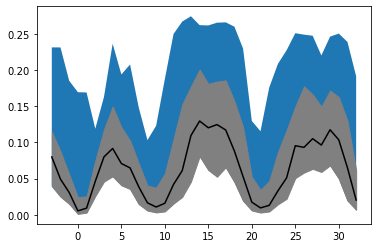

In [3]:
q95=growth_df.quantile(0.90)
q5=growth_df.quantile(0.10)
q32=q5=growth_df.quantile(0.32)
q68=growth_df.quantile(0.68)
plt.fill_between(x=q95.index, y1=q5, y2=q95)
plt.fill_between(x=q95.index, y1=q32, y2=q68, color="grey")
plt.plot(growth_df.median(), color="black")

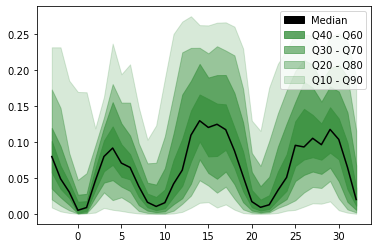

In [18]:
for q in np.arange(0.1,0.6,0.1):
    q_up = growth_df.quantile(1-q)
    q_down = growth_df.quantile(q)
    plt.fill_between(x=q_up.index, y1=q_down, y2=q_up, color="#3A913F", alpha=q*2)
plt.plot(growth_df.median(), color="black")
    
# Create the legend
patches_list=[]
patches_list.append(mpatches.Patch(color="black", label="Median"))
patches_list.append(mpatches.Patch(color="#3A913F", label="Q40 - Q60", alpha=0.8))
patches_list.append(mpatches.Patch(color="#3A913F", label="Q30 - Q70", alpha=0.6))
patches_list.append(mpatches.Patch(color="#3A913F", label="Q20 - Q80", alpha=0.4))
patches_list.append(mpatches.Patch(color="#3A913F", label="Q10 - Q90", alpha=0.2))

plt.legend(handles=patches_list)


In [5]:
growth_df.groupby("cluster").mean().transpose().plot()


KeyError: 'cluster'

In [ ]:
# overall mean by cluster
growth_df.groupby("cluster").mean().mean(axis=1)

In [ ]:
fix, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(15, 15))

axes = axes.flatten()
for cluster, cluster_df in growth_df.groupby("cluster"):
    del(cluster_df["cluster"])
    ax = axes[cluster]
    cluster_df.transpose().plot(ax=ax, color="lightgrey", legend=False)
    cluster_df.median().transpose().plot(ax=ax, color="green", legend=False)
    ax.set_ylabel("Fraction Optimal")
    ax.set_xlabel("Months since war")
    ax.set_title("Cluster: " + str(cluster) + ", n: " + str(cluster_df.shape[0]))

In [ ]:
growth_df["latlon"] = growth_df.index
growth_df['latitude'] = growth_df["latlon"].str[0]
growth_df['longitude'] = growth_df['latlon'].str[1]
growth_df['longitude'] = growth_df[growth_df["longitude"]>180]["longitude"] - 360
#print(growth_df.longitude.min())

In [ ]:
growth_df["geometry"] = growth_df[['longitude','latitude']].apply(tuple, axis=1)
growth_df["geometry"] = growth_df["geometry"].apply(Point)
growth_df = growth_df[["cluster", "geometry"]]
growth_df = gpd.GeoDataFrame(growth_df)
growth_df.set_crs(epsg=4326).to_file("clusters_shp/clusters.shp")
growth_df

In [ ]:
buffered = gpd.GeoDataFrame(growth_df.buffer(0.65))
buffered["cluster"] = growth_df["cluster"]
buffered.columns=["geometry", "cluster"]
cluster_dict = {0:"high/low",
               1:"low/medium",
               2:"low/low",
               3:"low/high",
               4:"medium/medium"
               }
buffered["cluster_names"] = buffered["cluster"].map(cluster_dict)


In [ ]:
global_map = gpd.read_file("../geospatial_information/world_map/ne_10m_admin_0_countries.shp")


In [ ]:
cluster_dissolved = buffered.dissolve(by="cluster")
cluster_dissolved.set_crs(epsg=4326,inplace=True)
cluster_dissolved.to_crs(global_map.crs,inplace=True)
cluster_dissolved["cluster"] = cluster_dissolved.index
ax = cluster_dissolved.plot(column="cluster_names", legend=True)
fig = plt.gcf()
fig.set_size_inches(15,15)
global_map.plot(ax=ax, color="white", edgecolor="black")
ax.set_ylim(18,55)
ax.set_xlim(-130,-65)

In [ ]:
growth_df

In [ ]:
growth_df["cluster_names"] = growth_df["cluster"].map(cluster_dict)


In [ ]:
eez = gpd.read_file("World_EEZ_v11_20191118/eez_v11.shp")
eez = eez[eez["SOVEREIGN1"]=="United States"]
eez

In [ ]:
growth_df.set_crs(epsg=4326,inplace=True)
growth_df.to_crs(global_map.crs,inplace=True)
ax = geoplot.voronoi(growth_df, hue="cluster_names", legend=True, linewidth=0.1)
legend = ax.get_legend()
legend.set_title("Suitability before/during ASRS")
legend.set_facecolor="white"
fig = plt.gcf()
fig.set_size_inches(15,15)
eez.to_crs(global_map.crs).plot(ax=ax,facecolor="none", edgecolor='white', lw=1.5)
global_map.plot(ax=ax, color="white", edgecolor="black")
ax.set_ylim(17,53)
ax.set_xlim(-130,-60)
plt.savefig("clusters_US.png", dpi=300, bbox_inches="tight")